#### Name: Mansi Mrugen Shah (ws2865)

## Model 2: Using fine tuning and VGG Model

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from sklearn import preprocessing
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import EarlyStopping

from keras import models
from keras import layers
from keras import optimizers


print(tf.__version__)

1.15.0


**Load VGG Model**

In [0]:
from keras.applications import VGG16

vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [0]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

**Train last 4 layers with Data Augmentation**

In [0]:
# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
  layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
  print(layer, layer.trainable)


<keras.engine.input_layer.InputLayer object at 0x7f255f5ff0b8> False
<keras.layers.convolutional.Conv2D object at 0x7f255f5ff7b8> False
<keras.layers.convolutional.Conv2D object at 0x7f255f5ff780> False
<keras.layers.pooling.MaxPooling2D object at 0x7f255f6164a8> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdfd5898> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdfda9b0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f25bdfdda20> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdfe7710> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdfe7f28> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdfede10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f25bdff75f8> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdffefd0> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdf83e48> False
<keras.layers.convolutional.Conv2D object at 0x7f25bdf8bd30> False
<keras.layers.pooling.MaxPooling2D object at 0x7f25bdf98518>

In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# unzip the folder
from zipfile import ZipFile
filename = "drive/My Drive/Colab Notebooks/JF30-1.zip"
with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print("done!")

done!


**Split the training and testing data**

In [0]:
classlabels = open("classlabels.txt", "r")
image = []
label = []

for line in classlabels:
    words = line.split()
    image.append(words[0][:-1])
    label.append(words[1])

df = pd.DataFrame([], columns = ["image", "label"])
df['image'] = image
df['label'] = label
df.tail()

df2 = df.reindex(np.random.permutation(df.index))
df2.shape

(1479, 2)

In [0]:
train_df = df2.head(1190)
test_df = df2.tail(289)

In [0]:
# Data generator for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
dataframe=train_df,
x_col = "image",
y_col = "label",
directory="./jpg/",
target_size=(128, 128))

Found 1190 validated image filenames belonging to 30 classes.


In [0]:
# Data generator for testing data

test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True)

test_generator = test_datagen.flow_from_dataframe(
dataframe=test_df,
x_col = "image",
y_col = "label",
directory="./jpg/",
class_mode = "categorical",
target_size=(128, 128),
shuffle=False)

Found 289 validated image filenames belonging to 30 classes.


**Check the baseline**

In [0]:
print("check the distribution of testing target variable:")
frequency = test_df['label'].value_counts(normalize =True)
print(frequency*100)

# The baseline of the model is 5.57%

check the distribution of testing target variable:
6     5.536332
28    5.536332
7     5.190311
10    5.190311
4     4.844291
29    4.844291
24    4.844291
14    4.498270
12    4.498270
20    4.152249
18    4.152249
2     4.152249
27    3.806228
22    3.806228
5     3.460208
19    3.460208
11    3.114187
23    3.114187
13    3.114187
8     2.768166
25    2.768166
17    2.422145
26    2.076125
16    2.076125
3     1.730104
21    1.384083
9     1.384083
30    1.038062
15    0.692042
1     0.346021
Name: label, dtype: float64


**Create the model**

VGG base model is added and then a fully connected layer is added followed by a softmax layer with 30 outputs as we have 30 categories of images.


In [0]:
    model = models.Sequential()
    # add vgg convolutional base model
    model.add(vgg_conv)
    # add new layers
    model.add(Flatten())
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(30))
    model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               4194816   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 30)               

**Compile the model**

The optimizer used here is Adam. The loss function is categorical_crossentropy because the output is multiclass. The metric is Accuracy.

In [0]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

**Fit Model**

In [0]:
history = model.fit_generator(train_generator,
epochs=40,
validation_data=test_generator,
verbose=1)

Epoch 1/40
38/38 [==============================] - 28s 732ms/step - loss: 2.5286 - acc: 0.2979 - val_loss: 4.5300 - val_acc: 0.2491
Epoch 2/40
38/38 [==============================] - 25s 653ms/step - loss: 1.1159 - acc: 0.6499 - val_loss: 3.7871 - val_acc: 0.3045
Epoch 3/40
38/38 [==============================] - 25s 662ms/step - loss: 0.7286 - acc: 0.7596 - val_loss: 2.9033 - val_acc: 0.3979
Epoch 4/40
38/38 [==============================] - 25s 665ms/step - loss: 0.6017 - acc: 0.8342 - val_loss: 1.1010 - val_acc: 0.6436
Epoch 5/40
38/38 [==============================] - 25s 667ms/step - loss: 0.5107 - acc: 0.8427 - val_loss: 0.9190 - val_acc: 0.7128
Epoch 6/40
38/38 [==============================] - 25s 661ms/step - loss: 0.3495 - acc: 0.8978 - val_loss: 1.4520 - val_acc: 0.6194
Epoch 7/40
38/38 [==============================] - 25s 660ms/step - loss: 0.3847 - acc: 0.8853 - val_loss: 1.2969 - val_acc: 0.6505
Epoch 8/40
38/38 [==============================] - 25s 668ms/step - 

**Minimum and Maximum Model Accuracy**

In [0]:
print("Minimum accuracy of Model: ", min(history.history['acc']))
print("Maximum accuracy of Model: ", max(history.history['acc']))

Minimum accuracy of Model:  0.3042016806722689
Maximum accuracy of Model:  0.984873949579832


**Minimum and Maximum Validation Accuracy**

In [0]:
print("Minimum accuracy of validation: ", min(history.history['val_acc']))
print("Maximum accuracy of validation: ", max(history.history['val_acc']))

Minimum accuracy of validation:  0.2491349480968858
Maximum accuracy of validation:  0.9653979238754326


**Plot Results**

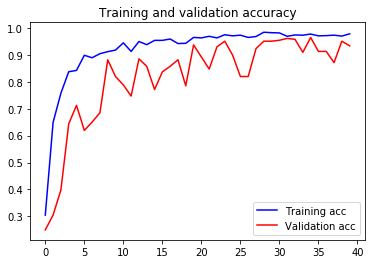

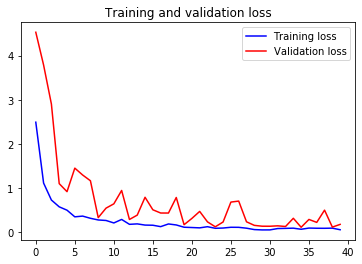

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


**Show the errors**

10/10 [==============================] - 5s 515ms/step
No of errors = 22/289


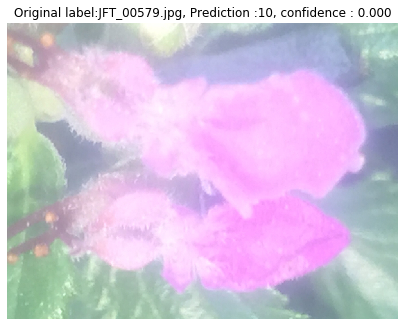

In [0]:
# Get the filenames from the generator

fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator

label2index = test_generator.class_indices
# Getting the mapping from class index to class label

idx2label = dict((v,k) for k,v in label2index.items())
# Get the predictions from the model using the generator

predictions = model.predict_generator(test_generator,verbose=1)

predicted_classes = np.argmax(predictions,axis=1)

errors = np.where(predicted_classes != ground_truth)[0]

print("No of errors = {}/{}".format(len(errors),test_generator.samples))

# Show the errors

#for i in range(len(errors)):
pred_class = np.argmax(predictions[errors[0]])
pred_label = idx2label[pred_class]
title = 'Original label:{}, Prediction :{}, confidence : {:.3f}'.format(
fnames[errors[0]].split('/')[0],
pred_label,
predictions[errors[0]][pred_class])
original = tf.keras.preprocessing.image.load_img('{}/{}'.format("./jpg/",fnames[errors[0]]))
plt.figure(figsize=[7,7])
plt.axis('off')
plt.title(title)
plt.imshow(original)
plt.show()


**Classification Report**

In [0]:
import sklearn.metrics as metrics
predictions = model.predict_generator(test_generator)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys()) 
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division='warn')
print(report) 

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
          10       0.83      1.00      0.91        15
          11       1.00      0.67      0.80         9
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00         9
          14       0.92      0.92      0.92        13
          15       0.67      1.00      0.80         2
          16       1.00      1.00      1.00         6
          17       0.86      0.86      0.86         7
          18       1.00      1.00      1.00        12
          19       1.00      1.00      1.00        10
           2       0.91      0.83      0.87        12
          20       0.92      1.00      0.96        12
          21       0.80      1.00      0.89         4
          22       1.00      0.91      0.95        11
          23       1.00      1.00      1.00         9
          24       1.00      0.64      0.78        14
          25       1.00    

**Conclusion**
This model is using Fine tuning technique to train CNN Classification Model for the Jena Flowers dataset. The pretrained model used here is VGG16 and the last 4 layers of the model is trained. Remaining layers are freezed. I have kept the initial layers intact and retrained the later layers. This technique is good at adapting to the new data. 

The baseline of the model is 5.57% and it is calculated using majority classification rule. The model and validation accuracy is exceeding baseline accuracy. The maximum validation accuracy is 96%. 